## Random Forest Classifier

#### Global Libraries

In [1]:
import pandas as pd
import numpy as np
import time
import datetime
import pickle
from os.path import isfile, join
import ast
import re
import itertools

#### Load the emotions.csv dataset

In [2]:
file = 'aj_data8.csv'
resume_flag = False
if isfile('ssl_emotions.csv'):
    file = 'ssl_emotions.csv'
    resume_flag = True
emotions = pd.read_csv(file, encoding='latin-1')
emotions.columns

Index(['Unnamed: 0', 'background', 'aeroplane', 'bicycle', 'bird', 'boat',
       'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
       'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa',
       'train', 'tv/monitor', 'red', 'n_red', 'yellow', 'n_yellow', 'green',
       'n_green', 'cyan', 'n_cyan', 'blue', 'n_blue', 'magenta', 'n_magenta',
       'emotion'],
      dtype='object')

### Export log functions

In [3]:
PRINT_SECONDS = 0
session_count = 0

def trackSession():
    global session_count
    if session_count == 0:
        session_count += 1
        return True
    else:
        return False
    return False

def setSession(file, flag=True):
    now = datetime.datetime.now()
    if flag:
        file.write("\n-------------------- SESSION - {} -------------------------\n".format(now.strftime("%Y-%m-%d %H:%M")))
    else:
        file.write("-------------------- SESSION - {} -------------------------\n".format(now.strftime("%Y-%m-%d %H:%M")))

def endSession(flag=True):
    now = datetime.datetime.now()
    if flag:
        return "\n-------------------- END SESSION - {} -------------------------\n".format(now.strftime("%Y-%m-%d %H:%M"))
    else:
        return "-------------------- END SESSION - {} -------------------------\n".format(now.strftime("%Y-%m-%d %H:%M"))
    return ""

def delayPrint(string, seconds, f="clf_logs.log"): # n seconds delay printing
    time.sleep(seconds)
    exportLogs(string, f)
    print(string)

def exportLogs(logs, f="clf_logs.log"):
    logs += "\n"
    if(isfile(f)):
        file = open(f, "a")
        if trackSession():
            setSession(file)
        file.write(logs)
        file.close()
    else:
        print("Log file does not exist!")
        print("Creating {} file...".format(f))
        file = open(f, "a+")
        if trackSession():
            setSession(file)
        file.write(logs)
        file.close()

### Save data functions

In [4]:
def initCtr(iter_file="iteration_counter.txt"):
    delayPrint("Checking {} file if empty...".format(iter_file), PRINT_SECONDS)
    with open(iter_file, "r+") as file:
        num_lines = sum(1 for line in file)
        if num_lines == 0:
            delayPrint("Initializing {} file...".format(iter_file), PRINT_SECONDS)
            file.write("0")
            delayPrint("Done initializing {}".format(iter_file), PRINT_SECONDS)
        else:
            delayPrint("{} not empty...".format(iter_file), PRINT_SECONDS)

def initTimeData(time_labels, time_file="time.txt"):
    delayPrint("Checking {} file if empty...".format(time_file), PRINT_SECONDS)
    with open(time_file, "r+") as file:
        num_lines = sum(1 for line in file)
        if num_lines == 0:
            delayPrint("Initializing {} file...".format(time_file), PRINT_SECONDS)
            for x in time_labels:
                file.write("{}: []\n".format(x))
            delayPrint("Done initializing {}".format(time_file), PRINT_SECONDS)
        else:
            delayPrint("{} not empty...".format(time_file), PRINT_SECONDS)

# load time.txt file for resuming purposes
def getTimeData(time_file="time.txt"):
    time_labels = []
    time_data = []
    with open(time_file, "r+") as file:
        delayPrint("Reading {} file...".format(time_file), PRINT_SECONDS)
        data = file.readlines()
        num_lines = len(data)
        for x in range(num_lines):
            dt = list(filter(None, re.split("(:\W)", data[x].rstrip()))) # filter removes blank strings in data[x] list
            time_label = dt[0]
            time_dt = ast.literal_eval(dt[len(dt) - 1])
            time_labels.append(time_label)
            time_data.append(time_dt)
            delayPrint("Fetched {} list...".format(time_label), PRINT_SECONDS)
    return time_labels, time_data

def saveTimeData(time_labels, time_data, time_file="time.txt"):
    with open(time_file, "w+") as file:
        print("Time Labels: {} Time Data: {}".format(time_labels, time_data))
        if len(time_labels) == len(time_data):
            for x in range(len(time_labels)):
                delayPrint("Saving time data...", PRINT_SECONDS)
                file.write("{} : {}\n".format(time_labels[x], time_data[x]))
            delayPrint("Saved time data...", PRINT_SECONDS)

def initScores(score_labels, score_file="scores.txt"):
    delayPrint("Checking {} file if empty...".format(score_file), PRINT_SECONDS)
    with open(score_file, "r+") as file:
        num_lines = sum(1 for line in file)
        if num_lines == 0:
            delayPrint("Initializing {} file...".format(score_file), PRINT_SECONDS)
            for x in score_labels:
                file.write("{}: []\n".format(x))
            delayPrint("Done initializing {}".format(score_file), PRINT_SECONDS)
        else:
            delayPrint("{} not empty...".format(score_file), PRINT_SECONDS)

# load scores.txt file for resuming purposes
def getScores(score_file="scores.txt"):
    score_labels = []
    scores = []
    with open(score_file, "r+") as file:
        delayPrint("Reading {} file...".format(score_file), PRINT_SECONDS)
        data = file.readlines()
        num_lines = len(data)
        for x in range(num_lines):
            dt = list(filter(None, re.split("(:\W)", data[x].rstrip()))) # filter removes blank strings in data[x] list
            score_label = dt[0]
            score = ast.literal_eval(dt[len(dt) - 1])
            score_labels.append(score_label)
            scores.append(score)
            delayPrint("Fetched {} list...".format(score_label), PRINT_SECONDS)
    return score_labels, scores

def saveScores(score_labels, scores, score_file="scores.txt"):
    with open(score_file, "w+") as file:
        print("Score Labels: {} Scores: {}".format(score_labels, scores))
        if len(score_labels) == len(scores):
            for x in range(len(score_labels)):
                delayPrint("Saving scores...", PRINT_SECONDS)
                file.write("{} : {}\n".format(score_labels[x], scores[x]))
            delayPrint("Saved scores...", PRINT_SECONDS)

#### Remove filename column and change column headers

In [5]:
if not resume_flag:
    emotions = emotions.drop('filename', axis=1)
    emotions.columns = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa',
           'train', 'tv/monitor', 'red', 'n_red', 'yellow',
           'n_yellow', 'green', 'n_green', 'cyan',
           'n_cyan', 'blue', 'n_blue', 'magenta',
           'n_magenta', 'emotion']
else:
    emotions = emotions.drop("Unnamed: 0", axis=1)
emotions

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,n_yellow,green,n_green,cyan,n_cyan,blue,n_blue,magenta,n_magenta,emotion
0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,8,0.002906,1,0.000258,3,0.000000,0,0.000026,2,joy
1,0.999616,0.0,0.000000,0.000384,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.003154,1,0.000048,1,0.000115,2,0.093388,7,joy
2,0.995435,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,4,0.523868,7,0.050700,10,0.000000,0,0.001069,6,sadness
3,0.997730,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.005760,3,0.003157,1,0.001407,5,0.030759,7,joy
4,0.996623,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,3,0.224839,5,0.305411,5,0.008561,4,0.031441,3,joy
5,0.730527,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.003894,0.000000,...,4,0.003192,1,0.000000,0,0.004544,3,0.009315,4,joy
6,0.971356,0.0,0.000000,0.000762,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,2,0.053292,4,0.098694,7,0.000021,1,0.007800,6,joy
7,0.980808,0.0,0.000000,0.000000,0.016949,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.177660,5,0.000494,1,0.027814,5,0.124649,5,AMBIGUOUS
8,0.861151,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,AMBIGUOUS
9,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000051,1,AMBIGUOUS


#### Show dataframe

In [6]:
# emotions = emotions[:616]
# emotions = emotions[:30]
# emotions['emotion'][100:len(emotions)] = np.nan
# emotions_c = pd.DataFrame()
emotions_c = emotions.copy()
emotions_c['emotion'] = ""
emotions

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,n_yellow,green,n_green,cyan,n_cyan,blue,n_blue,magenta,n_magenta,emotion
0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,8,0.002906,1,0.000258,3,0.000000,0,0.000026,2,joy
1,0.999616,0.0,0.000000,0.000384,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.003154,1,0.000048,1,0.000115,2,0.093388,7,joy
2,0.995435,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,4,0.523868,7,0.050700,10,0.000000,0,0.001069,6,sadness
3,0.997730,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.005760,3,0.003157,1,0.001407,5,0.030759,7,joy
4,0.996623,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,3,0.224839,5,0.305411,5,0.008561,4,0.031441,3,joy
5,0.730527,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.003894,0.000000,...,4,0.003192,1,0.000000,0,0.004544,3,0.009315,4,joy
6,0.971356,0.0,0.000000,0.000762,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,2,0.053292,4,0.098694,7,0.000021,1,0.007800,6,joy
7,0.980808,0.0,0.000000,0.000000,0.016949,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.177660,5,0.000494,1,0.027814,5,0.124649,5,AMBIGUOUS
8,0.861151,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,AMBIGUOUS
9,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000051,1,AMBIGUOUS


#### Drop rows with NaN values and segregate initial dataframes with labeled and unlabeled data

In [7]:
emotions_labeled = emotions.dropna()

# fix wrong spelling
emotions_labeled = emotions_labeled.replace(["aniticipation"], "anticipation")
# emotions_labeled.at[0, 'emotion'] = "joy"
# emotions_labeled.at[1, 'emotion'] = "joy"
# emotions_labeled.at[3, 'emotion'] = "anger"
# emotions_labeled.at[5, 'emotion'] = "disgust"
# emotions_labeled.at[6, 'emotion'] = "surprise"
# emotions_labeled.at[8, 'emotion'] = "trust"
# emotions_labeled.at[9, 'emotion'] = "trust"
# emotions_labeled.at[13, 'emotion'] = "disgust"
emotions_labeled

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,n_yellow,green,n_green,cyan,n_cyan,blue,n_blue,magenta,n_magenta,emotion
0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,8,0.002906,1,0.000258,3,0.000000,0,0.000026,2,joy
1,0.999616,0.0,0.000000,0.000384,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.003154,1,0.000048,1,0.000115,2,0.093388,7,joy
2,0.995435,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,4,0.523868,7,0.050700,10,0.000000,0,0.001069,6,sadness
3,0.997730,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.005760,3,0.003157,1,0.001407,5,0.030759,7,joy
4,0.996623,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,3,0.224839,5,0.305411,5,0.008561,4,0.031441,3,joy
5,0.730527,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.003894,0.000000,...,4,0.003192,1,0.000000,0,0.004544,3,0.009315,4,joy
6,0.971356,0.0,0.000000,0.000762,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,2,0.053292,4,0.098694,7,0.000021,1,0.007800,6,joy
7,0.980808,0.0,0.000000,0.000000,0.016949,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.177660,5,0.000494,1,0.027814,5,0.124649,5,AMBIGUOUS
8,0.861151,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,AMBIGUOUS
9,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000051,1,AMBIGUOUS


In [8]:
# replace NaN values with empty string
# reference: https://stackoverflow.com/questions/13851535/how-to-delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression
emotions_unlabeled = emotions.replace([np.nan], "")
emotions_unlabeled = emotions_unlabeled.drop(emotions_unlabeled[emotions_unlabeled['emotion'] != ""].index)

# adjust indices for the unlabeled set
emotions_unlabeled.index = range(len(emotions_unlabeled.index))
emotions_unlabeled

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,n_yellow,green,n_green,cyan,n_cyan,blue,n_blue,magenta,n_magenta,emotion


#### Set data X and target y for the labeled data and the unlabeled data

In [9]:
X_labeled, y_labeled = emotions_labeled.drop('emotion', axis=1), emotions_labeled['emotion']
X_unlabeled, y_unlabeled = emotions_unlabeled.drop('emotion', axis=1), emotions_unlabeled['emotion']
y_labeled

0             joy
1             joy
2         sadness
3             joy
4             joy
5             joy
6             joy
7       AMBIGUOUS
8       AMBIGUOUS
9       AMBIGUOUS
10        disgust
11            joy
12           fear
13            joy
14            joy
15        sadness
16            joy
17            joy
18           fear
19            joy
20            joy
21      AMBIGUOUS
22            joy
23            joy
24            joy
25        sadness
26        sadness
27            joy
28            joy
29           fear
          ...    
2970    AMBIGUOUS
2971     surprise
2972     surprise
2973     surprise
2974     surprise
2975     surprise
2976     surprise
2977     surprise
2978     surprise
2979    AMBIGUOUS
2980     surprise
2981    AMBIGUOUS
2982    AMBIGUOUS
2983    AMBIGUOUS
2984    AMBIGUOUS
2985     surprise
2986     surprise
2987    AMBIGUOUS
2988    AMBIGUOUS
2989    AMBIGUOUS
2990     surprise
2991    AMBIGUOUS
2992     surprise
2993    AMBIGUOUS
2994    AM

#### Split the dataset into training and test sets

In [10]:
from sklearn.model_selection import train_test_split
X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(X_labeled, y_labeled, random_state=0)

#### Whole process of constructing labeled data from predicted labels (Semi-supervised learning)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from operator import itemgetter
from sklearn.model_selection import GridSearchCV
# only use first default hyperparameters for experimenting only

# set hyperparameters of classifier
param_grid = {'n_estimators' : [100, 200],
              'criterion' : ['gini', 'entropy'],
              'max_depth' : [1, 2],
              'min_samples_leaf' : [1, 2, 3],
              'max_features' : ["auto", "sqrt", "log2", 0.9, 0.2],
              'oob_score' : [True],
              'n_jobs' : [-1],
              'random_state' : [42]}

# rfc = GridSearchCV(RandomForestClassifier(), param_grid, cv=10)
# rfc = RandomForestClassifier(n_estimators=500,
#                              criterion='entropy',
#                              max_leaf_nodes=16,
#                              n_jobs=-1,
#                              random_state=0)

# flag for using only base hyperparameters for all iterations
isUseBaseParams = True

time_file = "time.txt"
scores_file = "scores.txt"

# time lists
time_labels = ["Elapsed Time Iteration", "Time Passed"]
initTimeData(time_labels)
time_labels, time_data = getTimeData(time_file)
elapsed_time_list = []
elapsed_time_iter_list = time_data[0]
time_passed_list = time_data[1]

# scores lists
score_labels = ["Best Test Scores", "Best Cross-Validation Scores", "Out-of-bag Scores"]
initScores(score_labels)
score_labels, scores = getScores(scores_file)
best_score_list = scores[0]
best_cross_val_score = scores[1]
oob_score_list = scores[2]

iteration_counter = 0
start_time = datetime.datetime.now()

# print previous session
log_file = "clf_logs.log"
if isfile(log_file):
    with open(log_file, "r+") as file:
        lines = file.readlines()
        for line in lines:
            print(line)
            
delayPrint("---------- Start Time - {:s} ----------".format(str(start_time)), PRINT_SECONDS)

# define threshold parameter
threshold = 0.05

# compute number of iterations produced
emotions_labeled_len = len(emotions_labeled)
emotions_unlabeled_len = len(emotions_unlabeled)
while(emotions_labeled_len < len(emotions)):
    iteration_counter += 1
    estimated_rows = 1 if int((threshold*emotions_unlabeled_len)) < 1 else int((threshold*emotions_unlabeled_len))
    emotions_labeled_len += estimated_rows
    emotions_unlabeled_len -= estimated_rows

# show total number of models
num_models_settings = 1
for k, v in param_grid.items():
    num_models_settings *= len(v)
total_num_models = iteration_counter * num_models_settings
delayPrint("Total number of models: {}".format(total_num_models), PRINT_SECONDS)

# set default iteration_counter
iteration_counter_file = "iteration_counter.txt"
initCtr()
    
# loop if not all target values have emotions
# loop until everything is labeled
while(emotions['emotion'].isnull().values.any()):
    start_time_iter = datetime.datetime.now()
    
    # check saved interation_counter
    with open(iteration_counter_file, "r+") as file:
        data = file.readlines()
        iteration_counter = int(data[0])
    
    # show remaining number of models to produce
    num_models_current_settings = 1
    for k, v in param_grid.items():
        num_models_current_settings *= len(v)
    current_num_models = iteration_counter * num_models_current_settings
    rem_num_models = total_num_models - current_num_models
    delayPrint("Current number of models: {}".format(current_num_models), PRINT_SECONDS)
    delayPrint("Remaining number of models: {}".format(rem_num_models), PRINT_SECONDS)
    
    # incrementing iteration_counter
    iteration_counter += 1
        
    # grid search for random forest with 2 standard cross-validation
    # original cross-validation = 10
    model_file = 'ssl_rf_{}.pickle'.format(threshold*100) # model file name according to threshold percentage
    if not isfile(model_file):
        grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=2)
        grid_search.fit(X_train_labeled, y_train_labeled)
        best_params = grid_search.best_params_
    
    # use saved model if there is
    rfc = RandomForestClassifier()
    if isfile(model_file):
        delayPrint("Loading model...", PRINT_SECONDS)
        rfc = pickle.load(open(model_file, 'rb'))
    elif isUseBaseParams: # else-if for using only best base hyperparameters
        # comment else and unindent block to get best hyperparameters in each iteration
        # set best base parameters
        rfc.set_params(**best_params)

        # train the classifier
        rfc.fit(X_train_labeled, y_train_labeled)
    
    # save model per iteration
    with open(model_file, 'wb') as file:
        delayPrint("Saving model...", PRINT_SECONDS)
        pickle.dump(rfc, file)

    # gather class probabilities for each instance prediction
    y_pred_rfc = rfc.predict_proba(X_unlabeled)
    
    # show performance score per run
    y_pred_rfc_labeled = rfc.predict(X_test_labeled)
    # print("Accuracy score {}: {}".format(iteration_counter, accuracy_score(y_test_labeled, y_pred_rfc_labeled)))
    delayPrint("Test set score: {:.2f}".format(grid_search.score(X_test_labeled, y_test_labeled)), PRINT_SECONDS)
    delayPrint("Best parameters: {}".format(grid_search.best_params_), PRINT_SECONDS)
    delayPrint("Best cross-validation score: {:.2f}".format(grid_search.best_score_), PRINT_SECONDS)
    delayPrint("Out-of-Bag Prediction Score: {:.2f}".format(rfc.oob_score_), PRINT_SECONDS)
    
    # store scores in list
    best_score_list.append(grid_search.score(X_test_labeled, y_test_labeled))
    best_cross_val_score.append(grid_search.best_score_)
    oob_score_list.append(rfc.oob_score_)
    saveScores(score_labels, [best_score_list, best_cross_val_score, oob_score_list], scores_file)

    # get highest class probability and pass it to a list
    probas = list(map((lambda x: x.max()), y_pred_rfc))
    yprfc = list(y_pred_rfc)

    # define threshold parameter
    # threshold = 0.05

    # tuple of predicted X_instances, y_instances, and score for each instance prediction
    probas_indices = list(map((lambda x: (X_unlabeled[x['index']:x['index']+1], rfc.classes_[list(x['probas']).index(max(list(x['probas'])))], max(list(x['probas'])))), [{'index' : i, 'probas' : list(p)} for i, p in enumerate(y_pred_rfc)]))

    # sort tuple according to its score value
    sorted_probas_indices = sorted(probas_indices, key=itemgetter(2), reverse=True)

    # get top emotions from the tuple based on its threshold value
    # print("Sorted probas indices: {}".format(len(sorted_probas_indices)))
    slice_quantity = int(len(sorted_probas_indices)*threshold)
    sorted_probas_indices_threshold = sorted_probas_indices[:1 if slice_quantity < 1 else slice_quantity]

    # serpate values for X and y instances of top emotions
    # len(sorted_probas_indices_threshold)
    topy_emotions = list(map((lambda x: x[1]), sorted_probas_indices_threshold))
    # print(y_pred_rfc)
    # print(sorted_probas_indices_threshold)
    delayPrint("{}".format(topy_emotions), PRINT_SECONDS)
    topx_emotions_list = sorted_probas_indices_threshold

    # instantiate new DataFrame for accumulating all X instances
    topx_emotions = pd.DataFrame()

    # gather all X predicted instances
    for x in topx_emotions_list:
        topx_emotions = topx_emotions.append(x[0], sort=False)
    
    # adjust indices for topx_emotions
    # topx_emotions.index = range(len(topx_emotions.index))
    
    # remove topx_emotions from the unlabeled data
    # print(list(X_unlabeled.index))
    emotions_unlabeled = X_unlabeled.drop(X_unlabeled.index[list(topx_emotions.index)])

    # add again the target column of the universal set of unlabeled data
    emotions_unlabeled['emotion'] = None

    # set proper indices for the unlabeled set
    # emotions_unlabeled.index = range(len(emotions_labeled.index), len(emotions_labeled.index) + len(emotions_unlabeled.index))
    emotions_unlabeled.index = range(len(emotions_unlabeled.index))
    
    # add target column from the newly instantiated DataFrame along with its instances
    topx_emotions['emotion'] = topy_emotions
    top_emotions = topx_emotions

    # add the predicted instances DataFrame to the universal set of labeled data
    emotions_labeled = pd.concat([emotions_labeled, top_emotions], axis=0, sort=False)

    # fix previous indices to its current position in DataFrame
    emotions_labeled.index = range(len(emotions_labeled.index))

    # combine universal labeled and unlabeled sets into one
    emotions = pd.concat([emotions_labeled, emotions_unlabeled], axis=0, sort=False)

    # adjust indices for universal emotions set
    emotions.index = range(len(emotions.index))
    
    # Set data X and target y for the labeled data and the unlabeled data
    X_labeled, y_labeled = emotions_labeled.drop('emotion', axis=1), emotions_labeled['emotion']
    X_unlabeled, y_unlabeled = emotions_unlabeled.drop('emotion', axis=1), emotions_unlabeled['emotion']
    X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(X_labeled, y_labeled, random_state=0)
    # print("Len of emotions_labeled: {}".format(len(emotions_labeled)))
    # print("Len of emotions_unlabeled: {}".format(len(emotions_unlabeled)))
    # print("Len of emotions: {}".format(len(emotions)))
    # print("Len of x_labeled:{}".format(len(X_labeled)))
    # print("Len of y_labeled:{}".format(len(y_labeled)))
    # print("Len of x_unlabeled:{}".format(len(X_unlabeled)))
    # print("Len of y_unlabeled:{}".format(len(y_unlabeled)))
    
    # time computations
    end_time_iter = datetime.datetime.now()
    elapsed_time_iter = end_time_iter - start_time_iter
    elapsed_time_iter_list.append(str(elapsed_time_iter))
    time_passed = end_time_iter - start_time
    time_passed_list.append(str(time_passed))
    print("elapsed_time_iter_list: {}".format(elapsed_time_iter_list))
    print("time_passed_list: {}".format(time_passed_list))
    saveTimeData(time_labels, [elapsed_time_iter_list, time_passed_list], time_file)
    delayPrint("Accuracy {} elapsed time: {}".format(iteration_counter, str(elapsed_time_iter)), PRINT_SECONDS)
    delayPrint("Time passed: {}\n".format(str(time_passed)), PRINT_SECONDS)
               
    # saving interation_counter
    with open(iteration_counter_file, "w+") as file:
        file.write("{}".format(str(iteration_counter)))
    
    # save DataFrame per iteration
    emotions.to_csv("ssl_emotions.csv", encoding='utf-8')
    

end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
elapsed_time_list.append(elapsed_time)
delayPrint("---------- End Time - {:s} ----------".format(str(start_time)), PRINT_SECONDS)
delayPrint("Elapsed time: {}".format(elapsed_time), PRINT_SECONDS)

# save final DataFrame
emotions.to_csv("ssl_emotions.csv", encoding='utf-8')

# show DataFrame
emotions

Checking time.txt file if empty...
time.txt not empty...
Reading time.txt file...
Fetched Elapsed Time Iteration  list...
Fetched Time Passed  list...
Checking scores.txt file if empty...
scores.txt not empty...
Reading scores.txt file...
Fetched Best Test Scores  list...
Fetched Best Cross-Validation Scores  list...
Fetched Out-of-bag Scores  list...


-------------------- SESSION - 2018-09-21 01:09 -------------------------

Checking time.txt file if empty...

Initializing time.txt file...

Done initializing time.txt

Reading time.txt file...

Fetched Elapsed Time Iteration list...

Fetched Time Passed list...

Checking scores.txt file if empty...

Initializing scores.txt file...

Done initializing scores.txt

Reading scores.txt file...

Fetched Best Test Scores list...

Fetched Best Cross-Validation Scores list...

Fetched Out-of-bag Scores list...

---------- Start Time - 2018-09-21 01:09:54.742084 ----------

Total number of models: 13800

Checking iteration_counter.txt file if em


Saved scores...

['AMBIGUOUS']

Saving time data...

Saving time data...

Saved time data...

Accuracy 99 elapsed time: 0:00:00.502368

Time passed: 0:03:48.881998



Current number of models: 11880

Remaining number of models: 1920

Loading model...

Saving model...

Test set score: 0.62

Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 0.9, 'min_samples_leaf': 1, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}

Best cross-validation score: 0.28

Out-of-Bag Prediction Score: 0.27

Saving scores...

Saving scores...

Saving scores...

Saved scores...

['AMBIGUOUS']

Saving time data...

Saving time data...

Saved time data...

Accuracy 100 elapsed time: 0:00:00.478887

Time passed: 0:03:49.540231



Current number of models: 12000

Remaining number of models: 1800

Loading model...

Saving model...

Test set score: 0.63

Best parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 0.9, 'min_samples_leaf': 1, 'n_estimators

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,n_yellow,green,n_green,cyan,n_cyan,blue,n_blue,magenta,n_magenta,emotion
0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,8,0.002906,1,0.000258,3,0.000000,0,0.000026,2,joy
1,0.999616,0.0,0.000000,0.000384,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.003154,1,0.000048,1,0.000115,2,0.093388,7,joy
2,0.995435,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,4,0.523868,7,0.050700,10,0.000000,0,0.001069,6,sadness
3,0.997730,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.005760,3,0.003157,1,0.001407,5,0.030759,7,joy
4,0.996623,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,3,0.224839,5,0.305411,5,0.008561,4,0.031441,3,joy
5,0.730527,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.003894,0.000000,...,4,0.003192,1,0.000000,0,0.004544,3,0.009315,4,joy
6,0.971356,0.0,0.000000,0.000762,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,2,0.053292,4,0.098694,7,0.000021,1,0.007800,6,joy
7,0.980808,0.0,0.000000,0.000000,0.016949,0.000000,0.0,0.0,0.000000,0.000000,...,1,0.177660,5,0.000494,1,0.027814,5,0.124649,5,AMBIGUOUS
8,0.861151,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,AMBIGUOUS
9,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0,0.000000,0,0.000000,0,0.000000,0,0.000051,1,AMBIGUOUS


#### Check number of emotions in dataframe

In [12]:
model_file = "ssl_rf_{}.pickle".format(threshold*100)
if isfile(model_file):
    delayPrint("Loading model...", PRINT_SECONDS)
    rfc = pickle.load(open(model_file, 'rb'))
    # emotions_list = rfc.classes_
    emotions_list = sorted(emotions['emotion'].unique())
    for x in emotions_list:
        delayPrint("Number of {}: {}".format(x, len(emotions.loc[emotions['emotion'] == x])), PRINT_SECONDS)

Loading model...
Number of AMBIGUOUS: 607
Number of anger: 38
Number of anticipation: 145
Number of disgust: 29
Number of fear: 188
Number of joy: 171
Number of sadness: 196
Number of surprise: 503
Number of trust: 1123


#### Comparison check if all newly made labeled set is the same with the base labeled set

In [13]:
emotions_o = emotions.copy()
emotions_o['emotion'] = "" 
df = pd.concat([emotions_o, emotions_c])
df = df.reset_index(drop=True)
df_gpby = df.groupby(list(df.columns))
idx = [x[0] for x in df_gpby.groups.values() if len(x) == 1]
df.reindex(idx)

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,n_yellow,green,n_green,cyan,n_cyan,blue,n_blue,magenta,n_magenta,emotion


In [14]:
# y_pred_rfc_labeled = rfc.predict(X_labeled)
# type(y_pred_rfc_labeled)
# y_pred_rfc_labeled
# accuracy_score(np.array(y_labeled), y_pred_rfc_labeled)

In [15]:
# y_test = y_labeled.copy()
# y_test[0] = np.nan
# for x in range(len())

#### Define data X and target y for emotions data

In [16]:
X = emotions.drop('emotion', axis=1)
y = emotions['emotion']

#### Split the dataset into training and testing set

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#### Build final model from labeled data and show essential scores to evaluate the model

In [18]:
final_param_grid = {'n_estimators' : [100, 200, 500],
              'criterion' : ['gini', 'entropy'],
              'max_depth' : [1, 2],
              'min_samples_leaf' : [1, 2, 3],
              'max_features' : ["auto", "sqrt", "log2", 0.9, 0.2],
              'oob_score' : [True],
              'n_jobs' : [-1],
              'random_state' : [42]}
final_start_time = datetime.datetime.now()
final_model_file = "final_ssl_rf_{}.pickle".format(threshold*100)
final_gs_file = "final_gs_rf_{}.pickle".format(threshold*100)
final_grid_search = GridSearchCV(RandomForestClassifier(), final_param_grid)
if isfile(final_model_file) and isfile(final_gs_file):
    delayPrint("Loading final rfc model...", PRINT_SECONDS)
    final_rfc = pickle.load(open(final_model_file, 'rb'))
    delayPrint("Loading final grid search model...", PRINT_SECONDS)
    final_grid_search = pickle.load(open(final_gs_file, 'rb'))
else:
    final_grid_search = GridSearchCV(RandomForestClassifier(), final_param_grid, cv=10)
    final_grid_search.fit(X_train, y_train)
    final_best_params = final_grid_search.best_params_
    final_rfc = RandomForestClassifier()
    final_rfc.set_params(**final_best_params)
    final_rfc.fit(X_train, y_train)
final_elapsed_time = datetime.datetime.now() - final_start_time
print("Elapsed time: {}".format(final_elapsed_time))
print("Test set score: {:.2f}".format(final_grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(final_grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(final_grid_search.best_score_))

# save final models
if not isfile(final_model_file) or not isfile(final_gs_file):
    with open(final_model_file, 'wb') as file:
        delayPrint("Saving final rfc model...", PRINT_SECONDS)
        pickle.dump(final_rfc, file)
    with open(final_gs_file, 'wb') as file:
        delayPrint("Saving final grid search model...", PRINT_SECONDS)
        pickle.dump(final_grid_search, file)

Loading final rfc model...
Loading final grid search model...
Elapsed time: 0:00:00.022063
Test set score: 0.57
Best parameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': 0.9, 'min_samples_leaf': 1, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': True, 'random_state': 42}
Best cross-validation score: 0.63


#### 10 Standard cross-fold validation

In [19]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(final_rfc, X, y, cv=10)
# scores
print("10 standard cross-fold validation mean score: {}".format(np.mean(scores)))

10 standard cross-fold validation mean score: 0.5926384180022427


#### Visualization of trees

In [20]:
import graphviz
from sklearn.tree import export_graphviz
y = y.astype(np.str)
tree_path = "trees/emotions_tree{}.dot"
# export all the trees
for x in range(len(final_rfc.estimators_)):
    estimator = final_rfc.estimators_[x]
    export_graphviz(
            estimator,
            out_file=tree_path.format(x),
            feature_names=X.columns,
            class_names=y.unique(),
            rounded=True,
            filled=True
        )

with open("trees/emotions_tree0.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

# convert all .dots to .pngs
import pydot
for x in range(len(final_rfc.estimators_)):
    (graph,) = pydot.graph_from_dot_file(tree_path.format(x))
    graph.write_png('trees/emotions_tree{}.png'.format(x))

#### Classification Report

In [21]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
y2 = (y == "trust")
y3 = cross_val_predict(final_rfc, X, y, cv=10) # y preds for whole dataset
y4 = cross_val_predict(final_rfc, X, y2, cv=10) # binary y
print(classification_report(y, y3, target_names=final_rfc.classes_))

              precision    recall  f1-score   support

   AMBIGUOUS       0.58      0.73      0.65       607
       anger       0.00      0.00      0.00        38
anticipation       0.00      0.00      0.00       145
     disgust       0.00      0.00      0.00        29
        fear       0.00      0.00      0.00       188
         joy       0.00      0.00      0.00       171
     sadness       0.00      0.00      0.00       196
    surprise       0.49      0.85      0.62       503
       trust       0.66      0.81      0.73      1123

 avg / total       0.45      0.59      0.51      3000



/home/butchersix/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Confusion Matrix

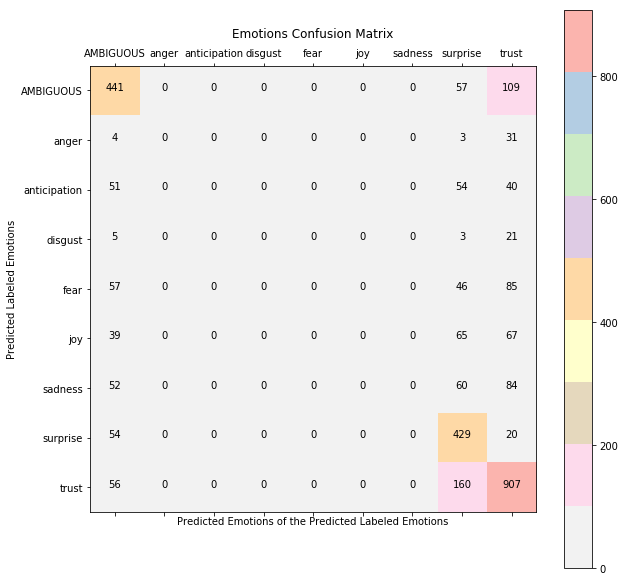

In [22]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y, y3)
plt.matshow(conf_mx, cmap=plt.cm.Pastel1.reversed())
# code for value per box
fmt = 'd'
thresh = conf_mx.max() / 2.
for i, j in itertools.product(range(conf_mx.shape[0]), range(conf_mx.shape[1])):
        plt.text(j, i, format(conf_mx[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if conf_mx[i, j] > thresh else "black")
plt.ylabel("Predicted Labeled Emotions")
plt.xlabel("Predicted Emotions of the Predicted Labeled Emotions")
plt.xticks(range(len(final_rfc.classes_)), final_rfc.classes_)
plt.yticks(range(len(final_rfc.classes_)), final_rfc.classes_)
plt.colorbar()
plt.gcf().set_size_inches(10,10)
plt.title("Emotions Confusion Matrix")
plt.gcf().savefig("Emotions Confusion Matrix.png")
plt.show()
# fig, axes = plt.figure()
# fig.set_size_inches(30, 20)
# plt.show()

#### Precision vs. Recall

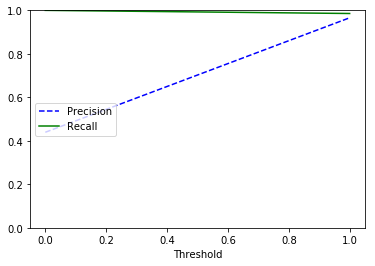

In [23]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(final_rfc, X, y4, cv=10)
precisions, recalls, thresholds = precision_recall_curve(y4, y_scores)

def plot_precision_recall_vs_threshold(precisions, recall, thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

#### Precision against recall

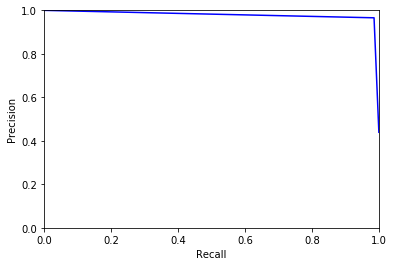

In [24]:
def plot_precision_recall(precisions, recall):
    plt.plot(recall,precisions,"b-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim([0,1])
    plt.ylim([0,1])
    
plot_precision_recall(precisions, recalls)
plt.show()

#### ROC Curve

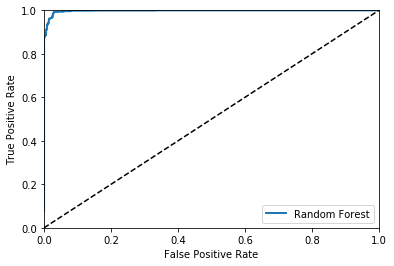

In [25]:
y_probas_forest = cross_val_predict(final_rfc, X, y4, cv=10, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y4, y_scores_forest)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [26]:
emotions_unlabeled

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,n_yellow,green,n_green,cyan,n_cyan,blue,n_blue,magenta,n_magenta,emotion
